# E-Commerce Store Analytics

### Problem Statement

Analytics for a startup that sells food products.  

**Goal:**  
* Understand how users behave in the mobile application.  

**Objectives:**  
* Analyze the sales funnel: determine how users progress toward making a purchase.  
  Identify how many users complete a purchase versus how many “get stuck” at earlier stages, and at which specific steps.  
* Investigate the results of an A/A/B experiment.  
  Designers suggested changing the fonts throughout the app, while managers worried this might confuse users.  
  It was agreed to make the decision based on the A/A/B test.  
  Users were split into three groups: two control groups (old fonts) and one experimental group (new fonts).  
  The task is to determine which font performs better.  

**Data Description:**  
* **EventName** — event name  
* **DeviceIDHash** — unique user identifier  
* **EventTimestamp** — event timestamp  
* **ExpId** — experiment ID: 246 and 247 = control groups, 248 = experimental group  

### Data Loading

In [12]:
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import os
from pandas.plotting import register_matplotlib_converters
import warnings
import datetime as dt
import plotly.express as px
import math as mth
import plotly.graph_objects as go

In [16]:
# load datasets with hypotheses and A/B test results
pth1 = '/datasets/logs_exp.csv'
pth2 = 'https://code.s3.yandex.net/datasets/logs_exp.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, sep='\t')
else:
    df = pd.read_csv(pth2, sep='\t')

In [18]:
# quick look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [19]:
df.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


#### Section Summary:
1. The dataset contains 4 columns and 244,126 rows; data types match the values.  
2. Column names are not formatted in lowercase snake_case.  

### Data Preprocessing

In [21]:
# bring column names to a consistent format
df = (df
.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_timestamp','ExpId': 'group'}) 
)

In [22]:
# rename group IDs to descriptive labels for convenience
dict = {246:'A1', 247:'A2', 248:'B'}
df['group'] = df['group'].map(dict)

In [23]:
# check for duplicates
df.duplicated().sum()

413

In [24]:
# remove duplicates
df = df.drop_duplicates().reset_index(drop=True);
df.duplicated().sum()

0

In [25]:
# check for missing values
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
group              0
dtype: int64

In [26]:
# add a column with the date in the required format
df['datetime'] = df['event_timestamp'].astype('datetime64[s]')

In [27]:
# add a date column
df['date'] = df['datetime'].dt.date

In [28]:
df.head()

,event_name,user_id,event_timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B,2019-07-25 11:48:42,2019-07-25


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   group            243713 non-null  object        
 4   datetime         243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


In [30]:
print('Number of events in the logs:', len(df))

Number of events in the logs: 243713


#### Section Summary:
1. Column names are not formatted in lowercase snake_case.  
2. Fewer than 0.2% duplicate rows were removed.  
3. No missing values were found.  
4. Two new columns were added: `datetime`, `date`.  
5. Number of events in the logs: 243,713.  

### Log Analysis

In [31]:
# check the number of unique users
df['user_id'].nunique()

7551

In [32]:
# check the average number of sessions per user
df.groupby('user_id')['event_name'].count().mean()

32.27559263673685

In [33]:
# check the time period covered by the data
print('Earliest date:', df['date'].min())
print('Latest date:', df['date'].max())
print('Log data covers a period of:', df['date'].max() - df['date'].min())

Earliest date: 2019-07-25
Latest date: 2019-08-07
Log data covers a period of: 13 days, 0:00:00


In [34]:
timeline = df.pivot_table(index=['group','date'],values='event_name',aggfunc='count')
timeline.columns = ['event_count']
timeline = timeline.reset_index()

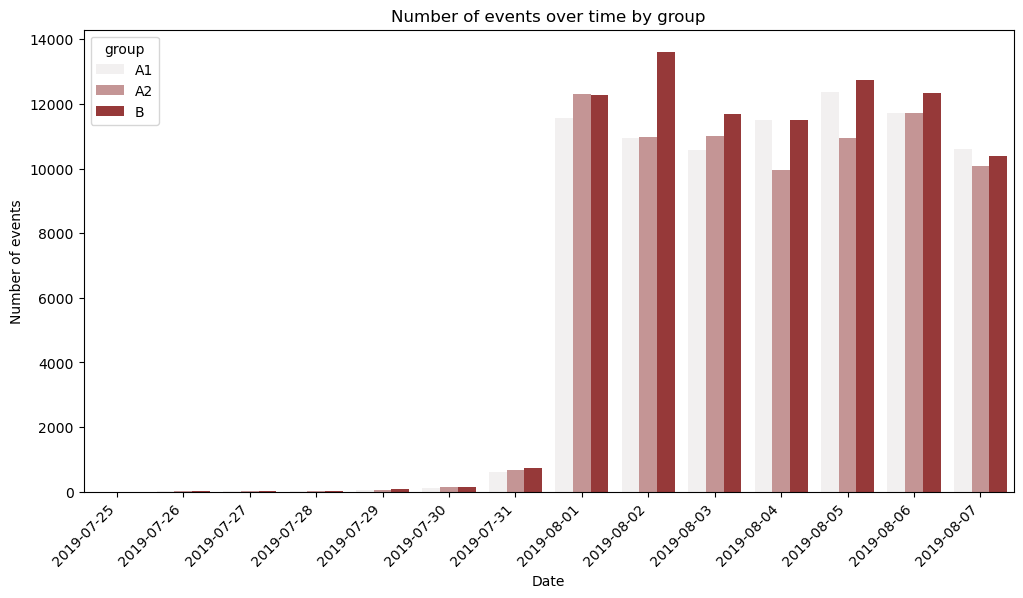

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=timeline, 
    x='date', 
    y='event_count', 
    hue='group', 
    color='brown', 
    ax=ax
).set(title='Number of events over time by group')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set(xlabel='Date', ylabel='Number of events')

plt.show()

The chart shows a significant increase in the number of events on August 1 — up to 12,000 sessions.  
Before that, the number of events per group ranged from single digits to fewer than 1,000.  
Between August 1 and 7, the distribution of sessions across groups was roughly equal.  
There is a small spike in the experimental group (B — 248) on August 2.  

In [37]:
# discard July data to avoid distortion
data = df.loc[(df['datetime'] >= '2019-08-01')]

data['date'].min()

datetime.date(2019, 8, 1)

In [38]:
# check the share of events remaining after filtering
print('Share of events remaining after filtering:', round(len(data)/len(df)*100, 2), '%')

Share of events remaining after filtering: 98.84 %


In [39]:
print('Number of events remaining after filtering:', len(data))

Number of events remaining after filtering: 240887


In [40]:
print(
    'Share of unique users remaining after filtering:',
    round(data['user_id'].nunique() / df['user_id'].nunique() * 100, 2),
    '%'
)

Share of unique users remaining after filtering: 99.77 %


In [41]:
print('Number of users remaining after filtering:', data['user_id'].nunique())

Number of users remaining after filtering: 7534


#### Section Summary:

1. On average, each user accounts for about 32 events.  
2. The dataset covers the period from July 26, 2019 to August 7, 2019.  
3. Complete daily session data is available starting from August 1.  
4. A total of 244,126 events were logged; after date filtering, 98% remained — 240,887 events.  
5. There were 7,551 unique users in the logs; after filtering, 99.7% remained — 7,534 unique users.  
6. Session distribution across groups is roughly equal for the period August 1–7.  
7. The number of sessions per group is approximately the same.  
8. There is no user overlap between groups.  

### Event Funnel Analysis

In [42]:
# check which events are present in the logs and how often they occur
# counts = data['event_name'].value_counts()
# percs = round(data['event_name'].value_counts(normalize=True)*100, 2)

stat = (
    data.groupby('event_name')['user_id']
    .nunique()
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)

stat['previous'] = stat['user_id'].shift(1).fillna(0)
stat['share of previous'] = round(stat['user_id'] / stat['previous'] * 100, 2)

stat.columns = [
    'Event name',
    'Number of users',
    'Users at previous step',
    'Share transitioned to step %'
]

stat

,Event name,Number of users,Users at previous step,Share transitioned to step %
1,MainScreenAppear,7419,0.0,inf
2,OffersScreenAppear,4593,7419.0,61.91
0,CartScreenAppear,3734,4593.0,81.30
3,PaymentScreenSuccessful,3539,3734.0,94.78
4,Tutorial,840,3539.0,23.74


* The most frequent event is navigating to the main screen.  
* 61% of users move on to the second step from the previous one.  
* 49% of users reach the cart step, and 94% of them complete a purchase.  
* The lowest transition rate is to the user guide page — about 11% of all users.  

In [43]:
funnel_stat = (data
               .query('event_name != "Tutorial"')
               .pivot_table(index='event_name',values='user_id', aggfunc=lambda x: x.nunique())
               .reset_index()
               .sort_values(by='user_id',ascending=False)
              )
funnel_stat

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [45]:
fig = go.Figure(go.Funnel(
    x = funnel_stat['user_id'],
    y = funnel_stat['event_name'], 
    textposition = "inside",
    textinfo = "value+percent previous",
    opacity = 0.65, marker = {"color": px.colors.sequential.RdBu,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "azure"}}
    ))
fig.update_traces(textfont_color='white')
fig.update_layout(
    title={
        'text': "Event Funnel",
        'y':0.9,
        'x':0.54,
        'xanchor': 'center',
        'yanchor': 'top'}) 
fig.show()

In [46]:
print(
    'Conversion rate of all users is',
    round(
        data.query('event_name == "PaymentScreenSuccessful"')['user_id'].nunique()
        / data['user_id'].nunique() * 100,
        2
    ),
    '%'
)

Conversion rate of all users is 46.97 %


In [47]:
data['user_id'].nunique()

7534

In [48]:
dau_total = (
    data.groupby('date').agg({'user_id': 'nunique'}).mean()
)

print('Average number of unique daily users:', int(dau_total))

Average number of unique daily users: 3676


#### Section Summary:

1. Proposed funnel sequence:  
   * Navigate to main screen — 100%  
   * Navigate to product page  
   * Navigate to cart  
   * Payment  

2. 30% of users drop off at the product page step.  
3. Users likely face difficulties navigating to or interacting with the product offers page.  
4. Conversion from the cart stage is 80%.  
5. Fewer than 1% of users view the app guide; this step will not be included in the funnel calculation.  
6. Average number of unique daily users: 3,676.  
7. Overall user conversion rate: 46.97%.  

### A/A/B Test Analysis

In [49]:
# check the number of users in each group
data.groupby('group').agg({'user_id': ['count', 'nunique']})

user_id        
        count nunique
group                
A1      79302    2484
A2      77022    2513
B       84563    2537

The A/A groups differ by 1.2%.  

In [53]:
# check for user overlaps across groups
data.groupby('user_id').agg({'group':'nunique'}).nunique()

group    1
dtype: int64

There are two control groups for the A/A experiment to verify the correctness of all mechanisms and calculations.  
Check whether statistical tests detect any differences between samples 246 and 247.  

Create a pivot table for test analysis.  

In [54]:
stat_data = (data.query('event_name != "Tutorial"')
            .pivot_table(index=['event_name'], values='user_id', columns='group'
                               , aggfunc=lambda x: x.nunique()).reset_index().sort_values(by='A1',ascending=False)
                 )

stat_data['total'] = data['user_id'].nunique() #stat_data.iloc[:,1:5].sum(axis=1)
stat_data[['shareA1','shareA2','shareB']] = stat_data.iloc[:,1:4].div(stat_data.total, axis=0)
#stat_data.iloc[:,1:4]

Using the most frequent event as an example, let’s examine the distribution across groups:  

In [55]:
sample = stat_data.query('event_name == "MainScreenAppear"')
sample

group,event_name,A1,A2,B,total,shareA1,shareA2,shareB
1,MainScreenAppear,2450,2476,2493,7534,0.325192,0.328643,0.3309


Null hypothesis: there is no statistical difference between the proportions of groups A and A1.  

Alternative hypothesis: there is a statistical difference between the proportions of groups A and A1.  

In [56]:
def z_test(group1, group2, event, df, pivot, alpha=0.05):

    successes1 = pivot[pivot.event_name == event][group1].iloc[0]
    successes2 = pivot[pivot.event_name == event][group2].iloc[0]
    
    trials1 = df[df.group == group1]['user_id'].nunique()
    trials2 = df[df.group == group2]['user_id'].nunique()
    
    # proportion of successes in the first group
    p1 = successes1 / trials1

    # proportion of successes in the second group
    p2 = successes2 / trials2
    
    print(successes1, successes2, trials1, trials2)

    # combined proportion of successes
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # difference in proportions
    difference = p1 - p2 

    # z-statistic
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # standard normal distribution (mean 0, std 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value:', p_value)

    if p_value < alpha:
        print('Reject the null hypothesis: significant difference between proportions')
    else:
        print('Failed to reject the null hypothesis: no significant difference between proportions')

In [57]:
z_test('A1', 'A2', 'MainScreenAppear', data, stat_data, alpha=0.05)

2450 2476 2484 2513
p-value: 0.7570597232046099
Failed to reject the null hypothesis: no significant difference between proportions


The statistical test showed that there is no statistically significant difference between the groups, and the null hypothesis is not rejected.  
Next, we will check the remaining events.  

In [58]:
for i in stat_data.event_name.unique():
    z_test('A1', 'A2', i, data, stat_data ,alpha=0.05)

2450 2476 2484 2513
p-value: 0.7570597232046099
Failed to reject the null hypothesis: no significant difference between proportions
1542 1520 2484 2513
p-value: 0.2480954578522181
Failed to reject the null hypothesis: no significant difference between proportions
1266 1238 2484 2513
p-value: 0.22883372237997213
Failed to reject the null hypothesis: no significant difference between proportions
1200 1158 2484 2513
p-value: 0.11456679313141849
Failed to reject the null hypothesis: no significant difference between proportions


For the remaining events, the test also showed no statistically significant difference between groups 246 (A1) and 247 (A2).  
The A/A test can therefore be considered successful, and the groups are split correctly.  

Now let’s move on to the A/B test.  

Null hypothesis: there is no statistical difference between the proportions of groups A1 and B.  
Alternative hypothesis: there is a statistical difference between the proportions of groups A1 and B.  

Let’s test this across all events at once.  

In [59]:
for i in stat_data.event_name.unique():
    z_test('A1', 'B', i, data, stat_data, alpha=0.05)

2450 2493 2484 2537
p-value: 0.2949721933554552
Failed to reject the null hypothesis: no significant difference between proportions
1542 1531 2484 2537
p-value: 0.20836205402738917
Failed to reject the null hypothesis: no significant difference between proportions
1266 1230 2484 2537
p-value: 0.07842923237520116
Failed to reject the null hypothesis: no significant difference between proportions
1200 1181 2484 2537
p-value: 0.2122553275697796
Failed to reject the null hypothesis: no significant difference between proportions


The statistical test showed that there is no statistically significant difference between groups 246 (A1) and 248 (B), and the null hypothesis is not rejected.  

Next, let’s compare the second control group with the experimental group.  

In [60]:
for i in stat_data.event_name.unique():
    z_test('A2', 'B', i, data, stat_data, alpha=0.05)

2476 2493 2513 2537
p-value: 0.4587053616621515
Failed to reject the null hypothesis: no significant difference between proportions
1520 1531 2513 2537
p-value: 0.9197817830592261
Failed to reject the null hypothesis: no significant difference between proportions
1238 1230 2513 2537
p-value: 0.5786197879539783
Failed to reject the null hypothesis: no significant difference between proportions
1158 1181 2513 2537
p-value: 0.7373415053803964
Failed to reject the null hypothesis: no significant difference between proportions


The statistical test again showed that there is no statistically significant difference between groups 247 (A2) and 248 (B), and the null hypothesis is not rejected.  

Let’s compare the results with the combined control group.  

In [61]:
# create a dataset from the original one with groups A1 and A2 combined into a single group
for_combined_test = data.query('event_name != "Tutorial"').reset_index(drop=True)

def comb(row):
    if 'A1' in row:
        return 'combined'
    elif 'A2' in row:
        return 'combined'
    else:
        return row

for_combined_test['group'] = for_combined_test['group'].apply(comb)
# for_combined_test['group'].unique()

# create a second pivot table with the combined groups
stat_data_comb = (
    for_combined_test.query('event_name != "Tutorial"')
    .pivot_table(
        index=['event_name'],
        values='user_id',
        columns='group',
        aggfunc=lambda x: x.nunique()
    )
    .reset_index()
)

In [62]:
for i in stat_data.event_name.unique():
    z_test('A2', 'B', i, data, stat_data, alpha=0.05)

2476 2493 2513 2537
p-value: 0.4587053616621515
Failed to reject the null hypothesis: no significant difference between proportions
1520 1531 2513 2537
p-value: 0.9197817830592261
Failed to reject the null hypothesis: no significant difference between proportions
1238 1230 2513 2537
p-value: 0.5786197879539783
Failed to reject the null hypothesis: no significant difference between proportions
1158 1181 2513 2537
p-value: 0.7373415053803964
Failed to reject the null hypothesis: no significant difference between proportions


When comparing the metrics of group 248 (B) with the combined control groups 246 (A1) and 247 (A2), no statistically significant differences were found for any of the events.  

However, with a significance level of 0.1, there is a 10% chance of incorrectly rejecting the null hypothesis when it is actually true.  
To account for this, we apply the Bonferroni correction.  
The significance level for each of the *m* comparisons is divided by *m*, relative to the significance level required for a single comparison.  
Thus, we divide the current significance level by the number of hypotheses.  

In [63]:
for i in stat_data.event_name.unique():
    z_test('A1', 'A2', i, data, stat_data , alpha=0.05/12)
    
for i in stat_data.event_name.unique():
    z_test('A1', 'B', i, data, stat_data, alpha=0.05/12)

2450 2476 2484 2513
p-value: 0.7570597232046099
Failed to reject the null hypothesis: no significant difference between proportions
1542 1520 2484 2513
p-value: 0.2480954578522181
Failed to reject the null hypothesis: no significant difference between proportions
1266 1238 2484 2513
p-value: 0.22883372237997213
Failed to reject the null hypothesis: no significant difference between proportions
1200 1158 2484 2513
p-value: 0.11456679313141849
Failed to reject the null hypothesis: no significant difference between proportions
2450 2493 2484 2537
p-value: 0.2949721933554552
Failed to reject the null hypothesis: no significant difference between proportions
1542 1531 2484 2537
p-value: 0.20836205402738917
Failed to reject the null hypothesis: no significant difference between proportions
1266 1230 2484 2537
p-value: 0.07842923237520116
Failed to reject the null hypothesis: no significant difference between proportions
1200 1181 2484 2537
p-value: 0.2122553275697796
Failed to reject the nul

In [64]:
for i in for_combined_test.event_name.unique():
    z_test('combined', 'B', i, for_combined_test, stat_data_comb, alpha=0.05/12)   

4926 2493 4995 2535
p-value: 0.3486684291093256
Failed to reject the null hypothesis: no significant difference between proportions
3062 1531 4995 2535
p-value: 0.44582745409482394
Failed to reject the null hypothesis: no significant difference between proportions
2504 1230 4995 2535
p-value: 0.18683558686831558
Failed to reject the null hypothesis: no significant difference between proportions
2358 1181 4995 2535
p-value: 0.6107918742187335
Failed to reject the null hypothesis: no significant difference between proportions


After applying the Bonferroni correction, the test results did not change.  

#### Section Summary:

1. A total of 16 hypotheses were tested in the A/A/B experiments.  
2. The A/A test was successful; the groups were formed correctly. Four null hypotheses were not rejected.  
3. All 12 hypotheses of equal proportions in the A/B tests (A1/B, A2/B, A/B) were not rejected.  
   The test can therefore be considered unsuccessful: the group with the changed font shows no statistical difference in user proportions at any step.  
   The font change had no impact on user behavior in any event.  
4. All tests were checked for Type I and Type II errors using the Bonferroni correction.  
   This did not affect the results — all hypotheses were not rejected.  

### Conclusions:  

1. A total of 16 hypotheses were tested in the A/A/B experiments. None of the hypotheses were rejected.  
2. The A/A test was successful; the groups were formed correctly.  
3. The A/B test can be considered unsuccessful: the group with the changed font shows no statistical difference in user proportions at any step. The font change had no impact on user behavior in any event.  
4. All tests were checked for Type I and Type II errors using the Bonferroni correction. This did not affect the results.  
5. There was no overlap of unique users between groups. The number of sessions per group was approximately the same.  
6. On average, each user accounted for about 32 events.  
7. The dataset covers the period from July 26, 2019 to August 7, 2019. For this study, the data from July 26 to July 31 was excluded due to insufficient volume.  
8. Proposed funnel sequence:  
   * Navigate to main screen  
   * Navigate to product page — 61.91% of users proceed from the previous step  
   * Navigate to cart — 81.30% of users proceed from the previous step  
   * Payment — 94.78% of users proceed from the previous step  
9. The exact funnel position of the "Tutorial" event was not identified, but it should be noted that this event occurs the least — about 11% of all users.  
10. The largest user drop-off occurs at the "OffersScreenAppear" event. Users may be experiencing difficulties navigating to or interacting with the product offers page, or they may lack sufficient triggers to proceed.  
11. The average number of unique daily users is 3,676.  
12. Overall user conversion rate: 46.97%.  